# Analyis of ERPs

## Optiones

In [2]:
bids_root_path_100 = "/media/marc/Medien/xmasoddballmatch-bids"
pipeline_name_100 = "pipeline01"        
    
bids_root_path_150 = "/media/marc/Medien/machristine-bids"
pipeline_name_150 = "pipeline_christine"

## Loading Dependencies and Defining Functions
Load MNE and read configuration file.

In [3]:
from configuration import load_configuration

import utils

from os.path import join
import mne
from mne_bids import make_bids_basename, read_raw_bids
from mne_bids.utils import get_entity_vals

import plotting

import seaborn as sns

%matplotlib widget

config = None


In [4]:
def difference_wave(evokeds_as_dict, conditions, grandaverage=False):
    out = [mne.combine_evoked([a, b], [1,-1]) for a, b in zip(
        evokeds_as_dict[conditions[0]], evokeds_as_dict[conditions[1]])]
    if grandaverage:
        return mne.grand_average(out)
    else:
        return out

## Read averaged ERPs from disk

Read averaged ERPs for each participant:

In [5]:
#%%capture
ids_100 = get_entity_vals(join(bids_root_path_100, "derivatives"), "sub") 
ave_filenames_100 = [utils.get_derivative_file_name(
        bids_root_path_100, id, pipeline_name_100, ".fif", suffix="ave") for id in ids_100]
all_evokeds_100 = [mne.read_evokeds(ave_filename) for ave_filename in ave_filenames_100]

ids_150 = get_entity_vals(join(bids_root_path_150, "derivatives"), "sub") 
ave_filenames_150 = [utils.get_derivative_file_name(
        bids_root_path_150, id, pipeline_name_150, ".fif", suffix="ave") for id in ids_150]
all_evokeds_150 = [mne.read_evokeds(ave_filename) for ave_filename in ave_filenames_150]

evokeds_list_as_dict_100 = {key: [] for key in config["conditions_of_interest"]}

for evokeds_list in all_evokeds_100:
    for evoked in evokeds_list:
        try:
            evokeds_list_as_dict_100[evoked.comment].append(evoked)
        except KeyError:
            pass
            print("Missing condition in list.")

evokeds_list_as_dict_150 = {key: [] for key in config["conditions_of_interest"]}

for evokeds_list in all_evokeds_150:
    for evoked in evokeds_list:
        try:
            evokeds_list_as_dict_150[evoked.comment].append(evoked)
        except KeyError:
            pass
            print("Missing condition in list.")

 dataset. Please consider the method self.add_proj.
No baseline correction applied
    Found the data of interest:
        t =    -300.78 ...     300.78 ms (random/standard)
        0 CTF compensation matrices available
        nave = 8350 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.
No baseline correction applied
    Found the data of interest:
        t =    -300.78 ...     300.78 ms (predictable/deviant)
        0 CTF compensation matrices available
        nave = 1785 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.
No baseline correction applied
    Found the data of interest:
        t =    -300.78 ...     300.78 ms (predictable/standard)
        0 CTF compensation matrices available
        nave = 8148 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.
No baseline correction applied
    Found the data of interest:
   

Turn list of dicts of ERPs into dict of lists of ERPs:

## Find Preak Latency and Window
Following Sussmann (2005), peak laency is defined as the latency where the differnce wave between deviant and standard tones in the random condition reaches its maximum (within the `Fz` channel).

In [6]:
# Find peak and find a window (±25ms) 
diff = difference_wave(evokeds_list_as_dict_150, ("random/deviant", "random/standard"), grandaverage=True)
peak_latency = diff.pick(picks="CZ").get_peak(tmin = .1, tmax = .2,  return_amplitude = True)[1]

peakwindow = (peak_latency-0.025, peak_latency+0.025)

print("Peak Latency is {} s.".format(peak_latency))

Identifying common channels ...
Peak Latency is 0.1328125 s.


In [7]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import ptitprince as pt
import pandas as pd
import matplotlib.gridspec as gridspec
import scipy as sp
from copy import deepcopy

plt.ioff()

In [11]:
def get_mean_amplitudes(evokeds, window, picks = "all"):

    means = []
    if isinstance(evokeds, list):
        for i, evoked in enumerate(evokeds):
            evoked = evoked.copy().pick(picks)

            _window = np.arange(evoked.time_as_index(window[0]),
                                evoked.time_as_index(window[1]))

            data = evoked.data[:, _window]
            mean = data.mean()
            means.append(mean)
    else:
        return get_mean_amplitudes([evokeds], window, picks)[0]

    return means


def plot_conditions(data, cond1, cond2, pick="FZ", 
                    p_val = .05, 
                    peak = .140, 
                    title=None, 
                    axs=None, 
                    rerefernce = None,  
                    plot_topomap = True,
                    topo_cmap="RdYlBu_r", 
                    palette = "Set2",
                    erp_lims = (-2,2),
                    mmn_lims = (-2, 2)):
    
    data = deepcopy(data)

    palette = matplotlib.cm.get_cmap(palette).colors
    
    if axs is None:
        fig = plt.figure(constrained_layout=False, figsize = (9,3));
        fig.suptitle(title)
        ax, ax2 = fig.subplots(ncols=2, sharey = True);
    else:
        ax = axs[0]
        ax2 = axs[1]
        ax3 = axs[2] if len(axs) > 2 else None
        ax4 = axs[3] if len(axs) > 3 else None
        
        N1_avg = np.int(np.round(np.min([e.nave for e in data[cond1]])))
        N2_avg = np.int(np.round(np.min([e.nave for e in data[cond2]])))
        
        ax.set_title(title.format(N1="($N_{{{{avg}}}} = {}$)".format(N1_avg), 
                                  N2="($N_{{{{avg}}}} = {}$)").format(N2_avg))

    if rerefernce is not None:
        data[cond1] = [mne.set_eeg_reference(ev.copy(), rerefernce)[0] for ev in data[cond1]]
        data[cond2] = [mne.set_eeg_reference(ev.copy(), rerefernce)[0] for ev in data[cond2]]
        
    # Calculate diff waves
    org_diff_waves = [mne.combine_evoked([e1,e2], [1,-1]) for e1,e2 in zip(data[cond1], data[cond2])]
        
    # Combine Channels
    data[cond1] = [mne.channels.combine_channels(ev.copy(), {"mean": mne.pick_channels(ev.info["ch_names"], pick)}) for ev in data[cond1]]
    data[cond2] = [mne.channels.combine_channels(ev.copy(), {"mean": mne.pick_channels(ev.info["ch_names"], pick)}) for ev in data[cond2]]
    
    # Calculate diff waves
    diff_waves = [mne.combine_evoked([e1,e2], [1,-1]) for e1,e2 in zip(data[cond1], data[cond2])]

    condition1 = np.vstack(np.squeeze([ev.copy().pick("mean").data for ev in data[cond1]])) * 10e5
    condition2 = np.vstack(np.squeeze([ev.copy().pick("mean").data for ev in data[cond2]])) * 10e5
    

    #T_obs, p_values, H0 =  mne.stats.permutation_t_test(condition1 - condition2, tail=0)
    
    # Plot mean MMN amplitudes
    mean_amplitudes_all = get_mean_amplitudes(diff_waves, peakwindow, picks = ["mean"]) 
    
    pdata_o = pd.DataFrame({"id":range(len(mean_amplitudes_all)), "mean_amplitude": mean_amplitudes_all})
    pdata = pdata_o.melt(id_vars=['id'])
    pdata["value"] = pdata["value"]  * 10e5
    
    ax2.axhline(0, .1, .9, color="k");
    ax2 = pt.RainCloud(x="variable", y = "value", data = pdata, ax = ax2, bw = .4, width_viol=.3, palette=palette);

    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)

    #ax2.set_ylim(mmn_lims[0]-.5,mmn_lims[1]+.5)

    #ax2.spines['left'].set_bounds(*mmn_lims)

    #ax2.set_yticks(mmn_lims)
    #ax2.set_yticklabels([str(t) for t in mmn_lims])

 

    # Plot ERPs   
    times = data[cond1][0].times
    
    ax.axhline(0, 0, 1, color="k");

    ax.plot(times, condition1.mean(axis=0)-condition2.mean(axis=0), color=palette[0], linewidth=2, label="difference");
    ax.plot(times, condition1.mean(axis=0), linestyle="dotted", color=palette[1], linewidth=1.5, label=cond1);
    ax.plot(times, condition2.mean(axis=0), linestyle="dashed", color=colors[2], linewidth=1.5, label=cond2);
    
    # Set Limits,Ticks and format Spines
    ax.set_ylim(erp_lims[0]-.25, erp_lims[1]+.25)
    
    
    ax2.get_yaxis().set_visible(False)
    
    ax.set_yticks(erp_lims)
    ax.spines['left'].set_bounds(*erp_lims)
    ax.spines['bottom'].set_bounds(0, .3)
    
    #ttest = sp.stats.ttest_1samp(pdata_o["mean_amplitude"], 0)
    
    #ax2.set_xlabel("$p = {p:.4f}$".format(p=ttest[1]));
    #ax2.set_ylabel("")
    
    ax.axvspan(peakwindow[0], peakwindow[1], color='k', alpha=0.1, label="MMN");

    ax.set_xlim(-.1,.3);
    
    # last_p = 1
    # span_start = 0
    
    # ax.legend(loc="upper left");
    
    # for i, p in enumerate(p_values):
        
    #     #print("i = ", i, "p =", p, "t = ", times[i])
        
    #     if last_p >= p_val and p > p_val:
    #         span_start = i
            
    #     if last_p < p_val and p >= p_val:
    #         #if i - span_start > 0
    #         #ax.axvspan(times[span_start], times[i], facecolor='#fcd703', edgecolor="orange", alpha=0.2);
    #         pass
        
    #     last_p = p
    # else:
    #     if last_p < p_val:
    #         #ax.axvspan(times[span_start], times[i], facecolor='#fcd703', edgecolor="orange", alpha=0.2, label="p < .05");
    #         pass

    gavg = mne.grand_average(org_diff_waves)

    vmax = lambda data: max(data) - .01
    vmin = lambda data: min(data) + .01
    
    if plot_topomap:
        mne.viz.plot_evoked_topomap(gavg, peak, axes = axs[2], cmap=topo_cmap, average = 0.50, show=False, colorbar=False, vmin = vmin, vmax=vmax)



    return fig if axs is None else axs

Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


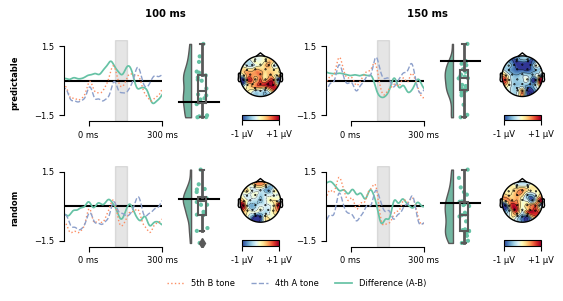

In [37]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib

colors = ['#66c2a5','#fc8d62','#8da0cb']

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 6

matplotlib.rcParams['axes.labelsize'] = "medium"

def plot_erp(ax, data, cond1, cond2, peakwindow, picks, palette = "Set2", erp_lims = (-1.5, 1.5)):
    data = deepcopy(data)

    # Get Palette
    palette = matplotlib.cm.get_cmap(palette).colors

    # Calculate diff waves
    org_diff_waves = [mne.combine_evoked([e1,e2], [1,-1]) for e1,e2 in zip(data[cond1], data[cond2])]
        
    # Combine Channels
    data[cond1] = [mne.channels.combine_channels(ev.copy(), {"mean": mne.pick_channels(ev.info["ch_names"], picks)}) for ev in data[cond1]]
    data[cond2] = [mne.channels.combine_channels(ev.copy(), {"mean": mne.pick_channels(ev.info["ch_names"], picks)}) for ev in data[cond2]]
    
    # Calculate diff waves
    diff_waves = [mne.combine_evoked([e1,e2], [1,-1]) for e1,e2 in zip(data[cond1], data[cond2])]

    condition1 = np.vstack(np.squeeze([ev.copy().pick("mean").data for ev in data[cond1]])) * 10e5
    condition2 = np.vstack(np.squeeze([ev.copy().pick("mean").data for ev in data[cond2]])) * 10e5

    # Plot MMN latency window
    ax.axvspan(peakwindow[0], peakwindow[1], color='k', alpha=0.1, label="MMN");

    # Plot ERPs   
    times = data[cond1][0].times
    
    ax.axhline(0, 0, 1, color="k")

    pdi, = ax.plot(times, condition1.mean(axis=0)-condition2.mean(axis=0), color=palette[0], linewidth=1.25, label="difference")
    pc1, = ax.plot(times, condition1.mean(axis=0), linestyle="dotted", color=palette[1], linewidth=1, label=cond1)
    pc2, = ax.plot(times, condition2.mean(axis=0), linestyle="dashed", color=colors[2], linewidth=1, label=cond2)

    ax.set_ylim(erp_lims[0]-.25, erp_lims[1]+.25)
    ax.set_xlim(-.1, .3)
    ax.set_yticks(erp_lims)
    ax.spines['left'].set_bounds(*erp_lims)
    ax.spines['bottom'].set_bounds(0, .3)

    return pc1, pc2, pdi
    

def plot_dist(ax, data, cond1, cond2, peakwindow, picks=["FZ"], palette = "Set2"):
    data = deepcopy(data)

    # Get Palette
    palette = matplotlib.cm.get_cmap(palette).colors

    # Combine Channels
    data[cond1] = [mne.channels.combine_channels(ev.copy(), {"mean": mne.pick_channels(ev.info["ch_names"], picks)}) for ev in data[cond1]]
    data[cond2] = [mne.channels.combine_channels(ev.copy(), {"mean": mne.pick_channels(ev.info["ch_names"], picks)}) for ev in data[cond2]]
    
    # Calculate diff waves
    diff_waves = [mne.combine_evoked([e1,e2], [1,-1]) for e1,e2 in zip(data[cond1], data[cond2])]

    # Plot mean MMN amplitudes
    mean_amplitudes_all = get_mean_amplitudes(diff_waves, peakwindow, picks = ["mean"]) 

    pdata_o = pd.DataFrame({"id":range(len(mean_amplitudes_all)), "mean_amplitude": mean_amplitudes_all})
    pdata = pdata_o.melt(id_vars=['id'])
    pdata["value"] = pdata["value"]  * 10e5
    
  
    ax.axhline(0, .1, .9, color="k");
    ax = pt.RainCloud(x="variable", y = "value", data = pdata, ax = ax, bw = .4, width_viol=.3, palette=palette)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_yaxis().set_visible(False)

def plot_topomap(ax, data, cond1, cond2, peakwindow, topo_cmap="RdYlBu_r"):
    data = deepcopy(data)

    peak = np.mean(peakwindow)
    
    # Calculate diff waves
    org_diff_waves = [mne.combine_evoked([e1,e2], [1,-1]) for e1,e2 in zip(data[cond1], data[cond2])]
        
    gavg = mne.grand_average(org_diff_waves)

    vmax = lambda data: max(data) - .01
    vmin = lambda data: min(data) + .01
    
    mne.viz.plot_evoked_topomap(gavg, peak, axes = ax, cmap=topo_cmap, average = 0.50, show=False, colorbar=False, vmin = vmin, vmax=vmax)

    # Remove Title
    ax.set_title("")


def plot_panel(fig, subplot_spec, data, c1, c2, peakwindow, picks=["FZ"]):

    dummy_axs = plt.figure().add_subplot()
    gs2 = gridspec.GridSpecFromSubplotSpec(ncols=4, nrows=3, height_ratios=[.1,1,.15], width_ratios=[.3, 6, 3, 3], wspace=.25, subplot_spec=subplot_spec)
    gs22 = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=2, height_ratios=[1,.1], subplot_spec=gs2[1, 3])
    axs2 = (fig.add_subplot(gs2[1, 1]), fig.add_subplot(gs2[1, 2]), fig.add_subplot(gs22[0, 0]), dummy_axs)
   
    # Add colorbar
    cb_wrapper = fig.add_subplot(gs22[1, 0])
    cb_wrapper.axis(False)
    cbar_ax = inset_axes(cb_wrapper, width="75%", height="85%", loc='center')

   

    norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
    cmap = matplotlib.cm.get_cmap('RdYlBu_r')
    cb = matplotlib.colorbar.ColorbarBase(cbar_ax, cmap=cmap,
                                    norm=norm,
                                    ticks = [-1,1],
                                    orientation='horizontal')
    cb.set_ticklabels(["-1 µV", "+1 µV"])

    # for l in cb.ax.xaxis.get_ticklabels():
    #     l.set_fontproperties(prop)
                            

    axs2[0].spines['top'].set_visible(False)
    axs2[0].spines['right'].set_visible(False)
    axs2[0].spines['bottom'].set_visible(True)


    #axs2[0].get_shared_y_axes().join(axs2[0], axs2[1])


    axs2[0].set_xticks([0,.3])
    axs2[0].set_xticklabels(["0 ms", "300 ms"])

    axs2[2].set_title("")
    axs2[1].get_xaxis().set_visible(False)

    
    plot_dist(axs2[1], data, c1, c2, peakwindow, picks=picks)
    plot_topomap(axs2[2], data, c1, c2, peakwindow)

    return plot_erp(axs2[0], data, c1, c2, peakwindow, picks=picks)


def hide_axis_but_keep_labels(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_facecolor((0,0,0,0))

    ax.set_xticks([])
    ax.set_yticks([])

#peakwindow = (.135 - .025, .135 +.025)
fig = plt.figure(tight_layout=True, figsize = (6.25, 3), dpi=100, facecolor="white")

gs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig, hspace=.1, wspace=.1)

plot_panel(fig, gs[0, 0], evokeds_list_as_dict_100, "predictable/5/deviant", "predictable/4/standard",  peakwindow)
plot_panel(fig, gs[0, 1], evokeds_list_as_dict_150, "predictable/5/deviant", "predictable/4/standard", peakwindow)

plot_panel(fig, gs[1, 0], evokeds_list_as_dict_100, "random/5/deviant", "random/4/standard", peakwindow)
lines = plot_panel(fig, gs[1, 1], evokeds_list_as_dict_150, "random/5/deviant", "random/4/standard", peakwindow)

# dummy axes for titles
dax_top_left = fig.add_subplot(gs[0,0])
hide_axis_but_keep_labels(dax_top_left)
dax_top_left.set_ylabel("predictable", fontweight = "bold", labelpad=20)
dax_top_left.set_title("100 ms", fontweight = "bold")

dax_top_right = fig.add_subplot(gs[0,1])
hide_axis_but_keep_labels(dax_top_right)
dax_top_right.set_title("150 ms", fontweight = "bold")

dax_bototm_left = fig.add_subplot(gs[1,0])
hide_axis_but_keep_labels(dax_bototm_left)
dax_bototm_left.set_ylabel("random", fontweight = "bold", labelpad=20)

# dummy axes for legend
dax_bottom = fig.add_subplot(gs[1,0:2])
hide_axis_but_keep_labels(dax_bottom)
dax_bottom.legend(lines, ("5th B tone", "4th A tone", "Difference (A-B)"), loc='upper center', bbox_to_anchor=(0.5, -0.05), frameon=False, ncol=3)

fig.savefig("/media/marc/Medien/xmas-oddballmatch/ba-thesis/input/figures/fig_fronto.pdf", bbox_inches='tight')
fig.savefig("/media/marc/Medien/xmas-oddballmatch/ba-thesis/input/figures/fig_fronto.png", bbox_inches='tight', dpi=270)

fig

Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


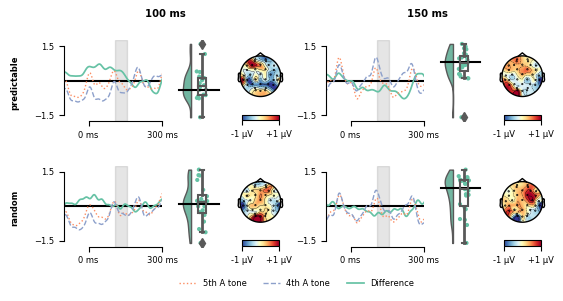

In [36]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib

colors = ['#66c2a5','#fc8d62','#8da0cb']

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 6

matplotlib.rcParams['axes.labelsize'] = "medium"

fig = plt.figure(tight_layout=True, figsize = (6.25, 3), dpi=100, facecolor="white")

gs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig, hspace=.1, wspace=.1)

plot_panel(fig, gs[0, 0], evokeds_list_as_dict_100, "predictable/5/standard", "predictable/4/standard",  peakwindow)
plot_panel(fig, gs[0, 1], evokeds_list_as_dict_150, "predictable/5/standard", "predictable/4/standard", peakwindow)

plot_panel(fig, gs[1, 0], evokeds_list_as_dict_100, "random/5/standard", "random/4/standard", peakwindow)
lines = plot_panel(fig, gs[1, 1], evokeds_list_as_dict_150, "random/5/standard", "random/4/standard", peakwindow)

# dummy axes for titles
dax_top_left = fig.add_subplot(gs[0,0])
hide_axis_but_keep_labels(dax_top_left)
dax_top_left.set_ylabel("predictable", fontweight = "bold", labelpad=20)
dax_top_left.set_title("100 ms", fontweight = "bold")

dax_top_right = fig.add_subplot(gs[0,1])
hide_axis_but_keep_labels(dax_top_right)
dax_top_right.set_title("150 ms", fontweight = "bold")

dax_bototm_left = fig.add_subplot(gs[1,0])
hide_axis_but_keep_labels(dax_bototm_left)
dax_bototm_left.set_ylabel("random", fontweight = "bold", labelpad=20)

# dummy axes for legend
dax_bottom = fig.add_subplot(gs[1,0:2])
hide_axis_but_keep_labels(dax_bottom)
dax_bottom.legend(lines, ("5th A tone", "4th A tone", "Difference"), loc='upper center', bbox_to_anchor=(0.5, -0.05), frameon=False, ncol=3)

fig.savefig("/media/marc/Medien/xmas-oddballmatch/ba-thesis/input/figures/fig_fronto2.pdf", bbox_inches='tight')
fig.savefig("/media/marc/Medien/xmas-oddballmatch/ba-thesis/input/figures/fig_fronto2.png", bbox_inches='tight', dpi=270)

fig

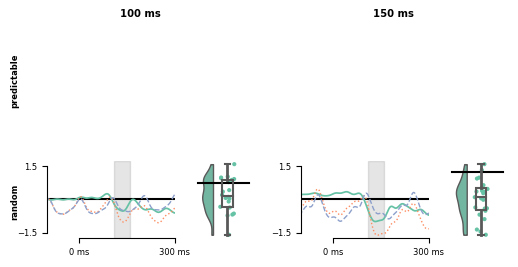

In [43]:
fig = plt.figure(tight_layout=True, figsize = (6.25, 3), dpi=100, facecolor="white")

gs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig, hspace=.1, wspace=.1)

#plot_panel(fig, gs[0, 0], evokeds_list_as_dict_100, "predictable/deviant", "predictable/standard",  peakwindow)
#plot_panel(fig, gs[0, 1], evokeds_list_as_dict_150, "predictable/deviant", "predictable/standard", peakwindow)

plot_panel(fig, gs[1, 0], evokeds_list_as_dict_100, "random/deviant", "random/standard", peakwindow)
plot_panel(fig, gs[1, 1], evokeds_list_as_dict_150, "random/deviant", "random/standard", peakwindow)



# dummy axes for titles
dax_top_left = fig.add_subplot(gs[0,0])
hide_axis_but_keep_labels(dax_top_left)
dax_top_left.set_ylabel("predictable", fontweight = "bold")
dax_top_left.set_title("100 ms", fontweight = "bold")

dax_top_right = fig.add_subplot(gs[0,1])
hide_axis_but_keep_labels(dax_top_right)
dax_top_right.set_title("150 ms", fontweight = "bold")

dax_bototm_left = fig.add_subplot(gs[1,0])
hide_axis_but_keep_labels(dax_bototm_left)
dax_bototm_left.set_ylabel("random", fontweight = "bold")

fig.savefig("/home/marc/ba-thesis/input/figures/fig_all.pdf", bbox_inches='tight')
fig.savefig("/home/marc/ba-thesis/input/figures/fig_all.png", bbox_inches='tight', dpi=270)


fig

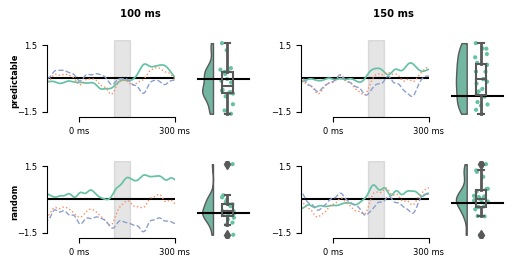

In [41]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

colors = ['#66c2a5','#fc8d62','#8da0cb']

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 6

matplotlib.rcParams['axes.labelsize'] = "medium"


def plot_panel(fig, subplot_spec, data, c1, c2, peakwindow, picks=["FZ"]):

    dummy_axs = plt.figure().add_subplot()
    gs2 = gridspec.GridSpecFromSubplotSpec(ncols=3, nrows=3, height_ratios=[.1,1,.15], width_ratios=[.3, 6, 3], wspace=.25, subplot_spec=subplot_spec)
    gs22 = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=2, height_ratios=[1,.1], subplot_spec=gs2[1, 2])
    axs2 = (fig.add_subplot(gs2[1, 1]), fig.add_subplot(gs2[1, 2]))

    axs2[0].spines['top'].set_visible(False)
    axs2[0].spines['right'].set_visible(False)
    axs2[0].spines['bottom'].set_visible(True)


    #axs2[0].get_shared_y_axes().join(axs2[0], axs2[1])


    axs2[0].set_xticks([0,.3])
    axs2[0].set_xticklabels(["0 ms", "300 ms"])

    plot_erp(axs2[0], data, c1, c2, peakwindow, picks=picks)
    plot_dist(axs2[1], data, c1, c2, peakwindow, picks=picks)

    axs2[1].get_xaxis().set_visible(False)
    axs2[1].get_yaxis().set_visible(False)
    #axs2[0].get_legend().remove()



fig = plt.figure(tight_layout=True, figsize = (6.25, 3), dpi=100, facecolor="white")

gs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig, hspace=.1, wspace=.1)

plot_panel(fig, gs[0, 0], evokeds_list_as_dict_100, "predictable/5/deviant", "predictable/4/standard", peakwindow = peakwindow, picks = ["M1", "M2"])
plot_panel(fig, gs[0, 1], evokeds_list_as_dict_150, "predictable/5/deviant", "predictable/4/standard", peakwindow = peakwindow, picks = ["M1", "M2"])

plot_panel(fig, gs[1, 0], evokeds_list_as_dict_100, "random/5/deviant", "random/4/standard", peakwindow = peakwindow, picks = ["M1", "M2"])
plot_panel(fig, gs[1, 1], evokeds_list_as_dict_150, "random/5/deviant", "random/4/standard", peakwindow = peakwindow, picks = ["M1", "M2"])

def hide_axis_but_keep_labels(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_facecolor((0,0,0,0))

    ax.set_xticks([])
    ax.set_yticks([])

# dummy axes for titles
dax_top_left = fig.add_subplot(gs[0,0])
hide_axis_but_keep_labels(dax_top_left)
dax_top_left.set_ylabel("predictable", fontweight = "bold")
dax_top_left.set_title("100 ms", fontweight = "bold")

dax_top_right = fig.add_subplot(gs[0,1])
hide_axis_but_keep_labels(dax_top_right)
dax_top_right.set_title("150 ms", fontweight = "bold")

dax_bototm_left = fig.add_subplot(gs[1,0])
hide_axis_but_keep_labels(dax_bototm_left)
dax_bototm_left.set_ylabel("random", fontweight = "bold")


fig.savefig("/home/marc/ba-thesis/input/figures/fig_mastioids.pdf", bbox_inches='tight')
fig.savefig("/home/marc/ba-thesis/input/figures/fig_mastoids.png", bbox_inches='tight', dpi=270)


fig

Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


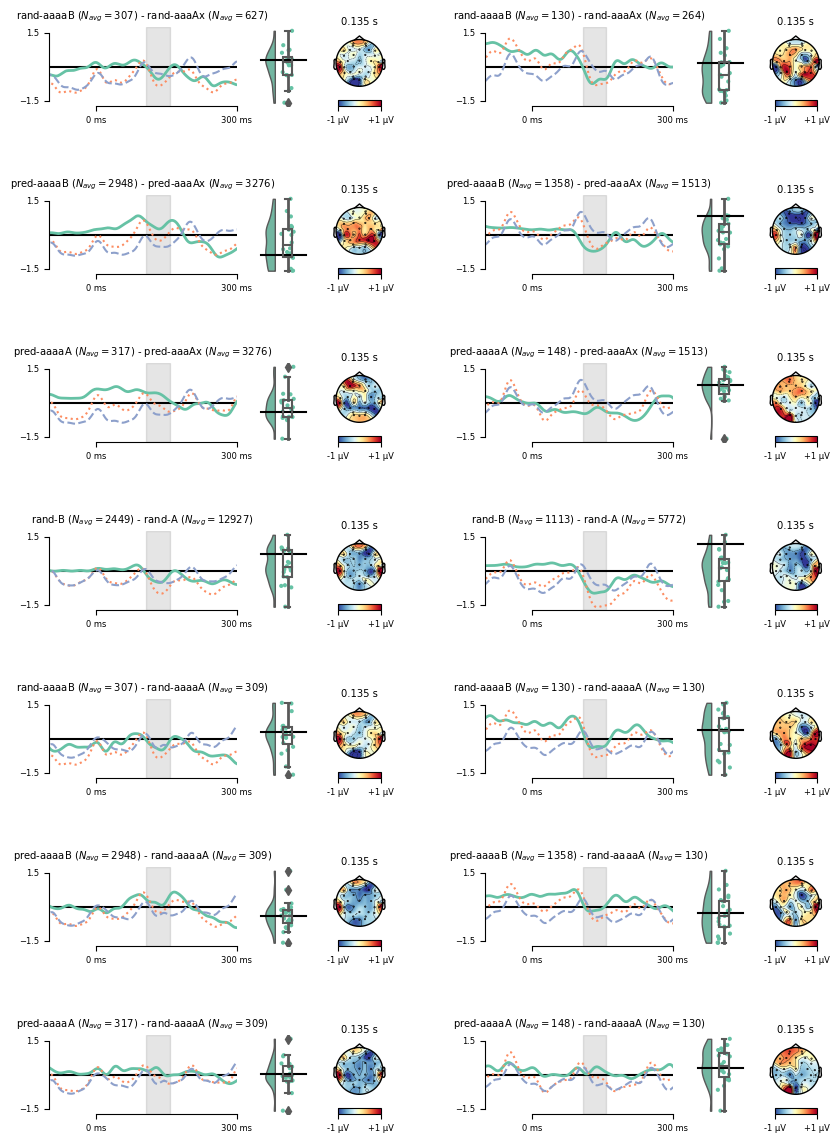

In [38]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

colors = ['#66c2a5','#fc8d62','#8da0cb']

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 6

matplotlib.rcParams['axes.labelsize'] = "medium"



def plot_panel(fig, subplot_spec, data, c1, c2, title = None):

    dummy_axs = plt.figure().add_subplot()
    gs2 = gridspec.GridSpecFromSubplotSpec(ncols=4, nrows=3, height_ratios=[.1,1,.15], width_ratios=[.3, 15, 3, 3], wspace=.25, subplot_spec=subplot_spec)
    gs22 = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=2, height_ratios=[1,.1], subplot_spec=gs2[1, 3])
    axs2 = (fig.add_subplot(gs2[1, 1]), fig.add_subplot(gs2[1, 2]), fig.add_subplot(gs22[0, 0]), dummy_axs)
   
    # Add colorbar
    cb_wrapper = fig.add_subplot(gs22[1, 0])
    cb_wrapper.axis(False)
    cbar_ax = inset_axes(cb_wrapper, width="75%", height="85%", loc='center')

   

    norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
    cmap = matplotlib.cm.get_cmap('RdYlBu_r')
    cb = matplotlib.colorbar.ColorbarBase(cbar_ax, cmap=cmap,
                                    norm=norm,
                                    ticks = [-1,1],
                                    orientation='horizontal')
    cb.set_ticklabels(["-1 µV", "+1 µV"])

    # for l in cb.ax.xaxis.get_ticklabels():
    #     l.set_fontproperties(prop)
                            

    axs2[0].spines['top'].set_visible(False)
    axs2[0].spines['right'].set_visible(False)
    axs2[0].spines['bottom'].set_visible(True)


    #axs2[0].get_shared_y_axes().join(axs2[0], axs2[1])


    axs2[0].set_xticks([0,.3])
    axs2[0].set_xticklabels(["0 ms", "300 ms"])

    axs2[2].set_title("")
    axs2[1].get_xaxis().set_visible(False)

    plot_conditions(data, c1, c2, title=title, axs=axs2, pick=["FZ"], peak = 0.135, erp_lims=(-1.5,1.5), mmn_lims=(-1.5, 1.5))
    #axs2[0].get_legend().remove()

    #if title is not None:
     #   axs2[0].set_title(title.format(N1="($#N_{{{{avg}}}} = {}$)".format(N1_avg), 
     #                                  N2="($N_{{{{avg}}}} = {}$)").format(N2_avg))

compare = { "rand-aaaaB {N1} - rand-aaaAx {N2}":("random/5/deviant", "random/4/standard"),
            "pred-aaaaB {N1} - pred-aaaAx {N2}":("predictable/5/deviant", "predictable/4/standard"),
            "pred-aaaaA {N1} - pred-aaaAx {N2}":("predictable/5/standard", "predictable/4/standard"),
            "rand-B {N1} - rand-A {N2}":("random/deviant", "random/standard"),
            #"pred-B {N1} vs. pred-A {N2}":("predictable/deviant", "predictable/standard"),
            "rand-aaaaB {N1} - rand-aaaaA {N2}":("random/5/deviant", "random/5/standard"),
            "pred-aaaaB {N1} - rand-aaaaA {N2}":("predictable/5/deviant", "random/5/standard"),
            "pred-aaaaA {N1} - rand-aaaaA {N2}":("predictable/5/standard", "random/5/standard")}

fig = plt.figure(tight_layout=True, figsize = (10, 2* len(compare)), facecolor="white");
gs = gridspec.GridSpec(ncols=2, nrows=len(compare), figure=fig, hspace=.5)

pick=["FZ", "F3", "F4", "FC1", "FC2"]

for i, (l, c) in enumerate(compare.items()):
    plot_panel(fig, gs[i, 0], evokeds_list_as_dict_100, c[0], c[1], l)
    plot_panel(fig, gs[i, 1], evokeds_list_as_dict_150, c[0], c[1], l)

fig

Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


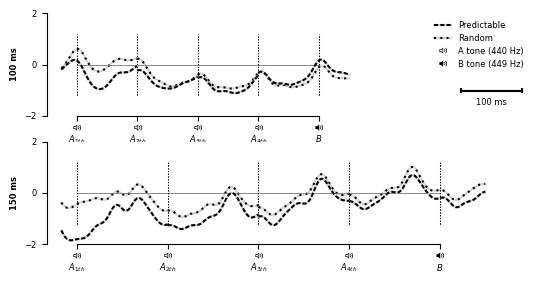

In [20]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
from matplotlib.legend_handler import HandlerBase
import copy


matplotlib.rcParams['font.size'] = 6
matplotlib.rcParams['pdf.fonttype'] = 3


dummy_fig = plt.figure()
dummy_ax = dummy_fig.add_subplot()

class TextHandler(HandlerBase):
    def create_artists(self, legend, orig_handle,xdescent, ydescent,
                        width, height, fontsize,trans):
        h = copy.copy(orig_handle)
        h.set_position((width/2.,height/2.))
        h.set_transform(trans)
        h.set_ha("center");h.set_va("center")
        fp = orig_handle.get_font_properties().copy()
        fp.set_size(fontsize)
        # uncomment the following line, 
        # if legend symbol should have the same size as in the plot
        h.set_font_properties(fp)
        return [h]

icon_font = FontProperties(fname=r"../remixicon.ttf", family = 'Remixicon') 

fig = plt.figure(figsize=(6.25,3))
gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig, hspace=.25)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])

import matplotlib.offsetbox
from matplotlib.lines import Line2D

class AnchoredHScaleBar(matplotlib.offsetbox.AnchoredOffsetbox):
    """ size: length of bar in data units
        extent : height of bar ends in axes units """
    def __init__(self, size=1, extent = 0.03, label="", loc=2, ax=None,
                 pad=0.4, borderpad=0.5, ppad = 0, sep=2, prop=None, 
                 frameon=True, linekw={}, **kwargs):
        if not ax:
            ax = plt.gca()
        trans = ax.get_xaxis_transform()
        size_bar = matplotlib.offsetbox.AuxTransformBox(trans)
        line = Line2D([0,size],[0,0], **linekw)
        vline1 = Line2D([0,0],[-extent/2.,extent/2.], **linekw)
        vline2 = Line2D([size,size],[-extent/2.,extent/2.], **linekw)
        size_bar.add_artist(line)
        size_bar.add_artist(vline1)
        size_bar.add_artist(vline2)
        txt = matplotlib.offsetbox.TextArea(label, minimumdescent=False)
        self.vpac = matplotlib.offsetbox.VPacker(children=[size_bar,txt],  
                                 align="center", pad=ppad, sep=sep) 
        matplotlib.offsetbox.AnchoredOffsetbox.__init__(self, loc, pad=pad, 
                 borderpad=borderpad, child=self.vpac, prop=prop, frameon=frameon,
                 **kwargs)


def plot_sequence_panel(ax, data, c, soa, **kwargs):
    if c is "predictable":
        evo0 = mne.grand_average(data[c+"/5/deviant"]).copy()
    else:
        evo0 = mne.grand_average(data[c+"/0/deviant"]).copy()

    evo0.crop(-.025,soa).pick("FZ")

    evo1 = mne.grand_average(data[c+"/1/standard"]).copy()
    evo1.crop(-.025,soa).pick("FZ")

    evo2 = mne.grand_average(data[c+"/2/standard"]).copy()
    evo2.crop(0,soa).pick("FZ")

    evo3 = mne.grand_average(data[c+"/3/standard"]).copy()
    evo3.crop(0,soa).pick("FZ")

    evo4 = mne.grand_average(data[c+"/4/standard"]).copy()
    evo4.crop(0,1.5*soa).pick("FZ")

    evo5 = mne.grand_average(data[c+"/5/deviant"]).copy()
    evo5.crop(0,soa).pick("FZ")

    ax.plot((0, 4*soa), (0, 0), color="grey", linewidth = .5)


    ax.plot(evo1.times +     0, np.squeeze(evo1.data * 10e5), label = c, color='lightgrey')
    ax.plot(evo2.times + 1*soa, np.squeeze(evo2.data * 10e5), color='lightgrey')
    ax.plot(evo3.times + 2*soa, np.squeeze(evo3.data * 10e5), color='lightgrey')
    ax.plot(evo4.times + 3*soa, np.squeeze(evo4.data * 10e5), color='lightgrey')
    #ax.plot(evo4.times + 4*soa, np.squeeze(evo4.data * 10e5), color='lightgrey')

    ax.plot(evo1.times +     0, np.squeeze(evo1.data * 10e5), color='black', label = c, **kwargs)
    ax.plot(evo2.times + 1*soa, np.squeeze(evo2.data * 10e5), color='black', **kwargs)
    ax.plot(evo3.times + 2*soa, np.squeeze(evo3.data * 10e5), color='black', **kwargs)
    ax.plot(evo4.times + 3*soa, np.squeeze(evo4.data * 10e5), color='black', **kwargs)
    #ax.plot(evo4.times + 4*soa, np.squeeze(evo4.data * 10e5), color='black', **kwargs)
    #ax.plot(evo5.times + 4*soa, np.squeeze(evo5.data), color='black')

    ax.axvline(x =     0, linewidth=.75, color='black', linestyle="dotted", ymin=.2, ymax=.8)
    ax.axvline(x = 1*soa, linewidth=.75, color='black', linestyle="dotted", ymin=.2, ymax=.8)
    ax.axvline(x = 2*soa, linewidth=.75, color='black', linestyle="dotted", ymin=.2, ymax=.8)
    ax.axvline(x = 3*soa, linewidth=.75, color='black', linestyle="dotted", ymin=.2, ymax=.8)
    ax.axvline(x = 4*soa, linewidth=.75, color='black', linestyle="dotted", ymin=.2, ymax=.8)

    
    #ax.axvline(x = 4*soa, linewidth=1, color='black', linestyle="dotted", ymin=.1, ymax=.9)


    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_bounds(-2, +2)
    ax.spines['bottom'].set_visible(True)
    ax.spines['bottom'].set_bounds(0, 4*soa)

    ax.set_xticks([0,soa,2*soa,3*soa,4*soa])
    ax.set_xticklabels(["\uf2a2\n$A_{1th}$", "\uf2a2\n$A_{2th}$", "\uf2a2\n$A_{3th}$", "\uf2a2\n$A_{4th}$", "\uf2a1\n$B$"], fontproperties = icon_font)

    ax.set_yticks([-2,0,2])

    ax.set_xlim(-.05, .75)


plot_sequence_panel(ax1, evokeds_list_as_dict_100, "predictable", .100, linestyle="dotted", dashes=(1, 2))
plot_sequence_panel(ax1, evokeds_list_as_dict_100, "random", .100,  linestyle="dashed", dashes=(2, 1))
plot_sequence_panel(ax2, evokeds_list_as_dict_150, "predictable", .150, linestyle="dotted", dashes=(1, 2))
plot_sequence_panel(ax2, evokeds_list_as_dict_150, "random", .150,  linestyle="dashed", dashes=(2, 1))

#ax1.legend()

ob = AnchoredHScaleBar(size=.1, label="100 ms", loc=4, frameon=False,
                       pad=0.6,sep=4, linekw=dict(color="black"),) 
ax1.add_artist(ob)



l11 = matplotlib.lines.Line2D([], [], linestyle="solid", color='lightgray')
l21 = matplotlib.lines.Line2D([], [], linestyle="dashed", dashes=(2, 1), color='black')

l12 = matplotlib.lines.Line2D([], [], linestyle="solid", color='lightgray')
l22 = matplotlib.lines.Line2D([], [], linestyle="dashed", dashes=(1, 2), color='black')

a_tone = matplotlib.text.Text(0,0, text='\uf2a2', color='black',size=30, ha="right", fontproperties = icon_font)
b_tone = matplotlib.text.Text(0,0,  text='\uf2a1', color='black',size=30, ha="right", fontproperties = icon_font)

handlermap = {type(a_tone) : TextHandler()}


ax1.legend([ (l11,l21), (l12,l22), a_tone, b_tone ], ["Predictable", "Random", "A tone (440 Hz)", "B tone (449 Hz)"], handler_map=handlermap, frameon=False)

ax1.set_ylabel("100 ms", fontweight = "bold")
ax2.set_ylabel("150 ms", fontweight = "bold")

fig.savefig("/home/marc/ba-thesis/input/figures/fig_sequences.pdf", bbox_inches='tight')
fig.savefig("/home/marc/ba-thesis/input/figures/fig_sequences.png", bbox_inches='tight', dpi=150)


fig

In [45]:
ax.transAxes.transform_point((3,4))

array([1531.25,  319.  ])